In [1]:
import pandas as pd
import seaborn as sns
sns.set()
sns.set_style("whitegrid")
sns.set_palette("GnBu_d")
from haversine import haversine # conda install -c conda-forge haversine
import matplotlib.pyplot as plt

In [2]:
brm = pd.read_csv("../resources/bremen.csv")
frb = pd.read_csv("../resources/freiburg.csv")

## Data Cleaning

In [3]:
def plot():
    fig, axes = plt.subplots(2, 2)
    axes[0, 0].scatter(brm["orig_lat"],brm["orig_lng"])
    axes[0, 1].scatter(brm["dest_lat"],brm["dest_lng"])
    axes[1, 0].scatter(frb["orig_lat"],frb["orig_lng"])
    axes[1, 1].scatter(frb["dest_lat"],frb["dest_lng"])    

def calc_distance(frame):
    frame_origin = (frame["orig_lat"]),(frame["orig_lng"])
    frame_destination = (frame["dest_lat"]),(frame["dest_lng"])
    frame_distance = []
    for row in range(len(frame)): # calc distance with haversine function for every row
        frame_distance.append(haversine(
            (frame_origin[0][row],frame_origin[1][row]),(frame_destination[0][row],frame_destination[1][row])
        ))
    frame["distance"] = frame_distance
    
def timedelta_to_hours(timedelta_array):
    return timedelta_array.map(lambda x: x / pd.Timedelta("1 hour"))

def drop_short_trips(frame):
    index = frame[(frame["distance"] < 0.1)].index
    frame.drop(index, inplace=True)
    frame = frame.reset_index(drop=True)
    return frame

def drop_slow_trips(frame):
    frame["kmh"] = (frame["distance"] / frame["trip_duration_in_hours"])
    index = frame[(frame["kmh"] < 5)].index
    frame.drop(index, inplace=True) 
    frame=frame.reset_index(drop=True)
    frame = frame.drop("kmh", 1)
    return frame

def row_count():
    return print("Number of Rows: " + "Bremen: "+ str(len(brm)) + ", Freiburg: " + str(len(frb)))

def delete_location(min_lat,max_lat,min_lng,max_lng,frame,keep):
    frame["delete"] = 0
    for row in range(len(frame)): # check if coordinates are in defined area
        if((min_lat < frame.at[row,"orig_lat"] < max_lat) & (min_lng < frame.at[row,"orig_lng"] < max_lng)):
            if((min_lat < frame.at[row,"dest_lat"] < max_lat) & (min_lng < frame.at[row,"dest_lng"] < max_lng)):
                frame.at[row,"delete"] = 1 # safe rows that fit criteria in extra column for better performance
    frame = frame[frame["delete"] == keep] # save all rows with delete = keep and overwrite frame
    frame = frame.drop(columns="delete") # delete extra column
    return frame.reset_index() # reset index before returning the frame

In [4]:
print("At the beginning we have:")
row_count()

At the beginning we have:
Number of Rows: Bremen: 157576, Freiburg: 127529


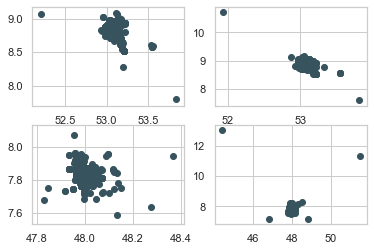

In [5]:
plot()

We looked up the location of repair centers and deleted the rides in the boundaries of them. For Freiburg 12 wrong captured rides and for bremen 0 rides where deleted.

In [6]:
frb = delete_location(47.991400,47.995164,7.795235,7.797257,frb,0)
brm = delete_location(53.059067,53.060892,8.786641,8.790375,brm,0)

Now we delete outliers by using rough coordinates from the plots above as boundaries

In [7]:
frb = delete_location(47.925,48.071,7.7,7.95,frb,1)
brm = delete_location(52.8,53.3,8.4,9.5,brm,1)

delete extra colums from resetting the index

In [8]:
frb = brm.drop(columns="index")
frb = brm.drop(columns="level_0")
brm = brm.drop(columns="index")
brm = brm.drop(columns="level_0")

The plots below demonstrate that all further outliers have been elimated:

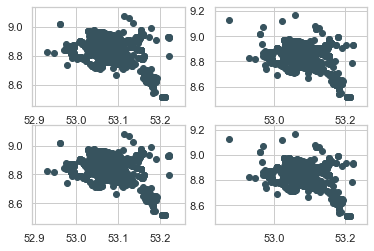

In [9]:
plot()

In [10]:
calc_distance(frb)
calc_distance(brm)

In [11]:
print(brm["trip_duration"].max())
print(frb["trip_duration"].max())

0 days 02:59:00.000000000
0 days 02:59:00.000000000


We checked the longest trip duration both for the city of Bremen and the city of Freiburg. By doing so we came to the conclusion that both durations are just under 3 hours. So we can save the data in hours to calculate the speed

In [12]:
frb["trip_duration_in_hours"] = timedelta_to_hours(frb["trip_duration"])
brm["trip_duration_in_hours"] = timedelta_to_hours(brm["trip_duration"])

In [13]:
row_count()

Number of Rows: Bremen: 157565, Freiburg: 157565


As part of the data cleaning we are making the assumption that all the trips with total distance under 100m are not valuable for us, such as unintended log-in, hence they are removed from the data set.  

In [14]:
frb = drop_short_trips(frb)
brm = drop_short_trips(brm)

Another assumption made for the purpose of data cleaning is that trips with average speed under 5kmh are also of no interest for us.
Due to this assumption another reduction in both datasets occurs.
And these are the final datasets on which we will perform our analysis.

In [15]:
brm = drop_slow_trips(brm)
frb = drop_slow_trips(frb)
brm = brm.drop(columns="trip_duration_in_hours")
frb = frb.drop(columns="trip_duration_in_hours")

In [16]:
print("We began with:  Bremen: 157576, Freiburg: 127529")
row_count()

We began with:  Bremen: 157576, Freiburg: 127529
Number of Rows: Bremen: 116237, Freiburg: 116237


In [17]:
brm.to_csv("../generated/brm_cleaned.csv")
frb.to_csv("../generated/frb_cleaned.csv")

In [18]:
brm

,day,time,b_number,city,trip_duration,orig_lat,orig_lng,dest_lat,dest_lng,distance
0,2019-06-14,22:30:00,20507,bremen,0 days 00:08:00.000000000,53.078923,8.884911,53.074731,8.876003,0.755886
1,2019-06-28,13:07:00,20507,bremen,0 days 00:49:00.000000000,53.078923,8.884911,53.073298,8.794316,6.084054
2,2019-06-28,15:01:00,20507,bremen,0 days 00:49:00.000000000,53.073529,8.794269,53.077716,8.897971,6.943062
3,2019-07-09,12:03:00,20507,bremen,0 days 00:13:00.000000000,53.078923,8.884911,53.067440,8.864807,1.853136
4,2019-07-09,12:23:00,20507,bremen,0 days 00:14:00.000000000,53.067418,8.864802,53.078923,8.884911,1.855081
...,...,...,...,...,...,...,...,...,...,...
116232,2019-11-17,16:37:00,20999,bremen,0 days 00:08:00.000000000,53.072835,8.814104,53.072084,8.828756,0.982436
116233,2019-11-17,18:39:00,20999,bremen,0 days 00:05:00.000000000,53.072071,8.828776,53.070533,8.821335,0.525679
116234,2019-11-18,09:23:00,20999,bremen,0 days 00:09:00.000000000,53.070369,8.821749,53.079360,8.813848,1.130559
116235,2019-11-19,15:35:00,20999,bremen,0 days 00:43:00.000000000,53.079591,8.813925,53.145093,8.910599,9.730569
